In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Necessary uploads for training
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math
from tqdm.auto import tqdm
from scipy import sparse
import json

import sys
import os
import gc
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder

import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
def fit_one_hot_encoder(amino_acid_vocab: List[str]) -> OneHotEncoder:
    """
    Creates an instance of the OneHotEncoder and fits it to the amino acid vocabulary.

    Parameters:
        amino_acid_vocab (List[str]): List of unique amino acids in the dataset.

    Returns:
        OneHotEncoder: The trained one-hot encoder object.
    """
    # Create an instance of the OneHotEncoder.
    # The 'ignore' option creates an array full of zeros for the uncommon amino acids.
    encoder = OneHotEncoder(categories='auto', sparse=True, handle_unknown='ignore')

    # Fit the encoder to the amino acid vocabulary.
    encoder.fit(np.array(amino_acid_vocab).reshape(-1, 1))

    return encoder


def strings_to_one_hot(fitted_encoder: OneHotEncoder,
                       sequence_array: np.ndarray) -> np.ndarray:
    """
    Converts an array of amino acid sequences to an array of one-hot encoded sparse matrices.

    Parameters:
        fitted_encoder (OneHotEncoder): A fitted OneHotEncoder object.
        sequence_array (np.ndarray): An array of amino acid sequences.

    Returns:
        np.ndarray: An array of one-hot encoded sparse matrices, one for each amino acid sequence in the input array.
    """
    # Convert each string to a one-hot vector.
    one_hot_vectors = []
    max_len = max(len(s) for s in sequence_array)
    for i, s in enumerate(sequence_array):
        # Convert string to list of characters.
        char_list = np.array(list(s)).reshape(-1, 1)

        # Transform the character list to a one-hot vector.
        onehot = fitted_encoder.transform(char_list)

        # Pad one-hot vectors with zeros until max_len.
        padding_width = ((0, max_len - len(s)), (0, 0))
        padded_onehot = np.pad(onehot.toarray(), padding_width, mode='constant')

        # Append the sparse one-hot matrix to the list of one-hot vectors.
        one_hot_vectors.append(sparse.csr_matrix(padded_onehot, dtype=np.float32))

        # Print progress
        if i % 50000 == 0:
            print('step:', i)

    return np.array(one_hot_vectors)


# fit the one-hot encoder
one_hot_encoder_sequences = fit_one_hot_encoder(AMINO_ACID_VOCABULARY)

## Load the preprocessed dataframes and encode them

In [8]:
train_df = pd.read_csv('/kaggle/input/pfam-processed-df/train.csv', )
val_df = pd.read_csv('/kaggle/input/pfam-processed-df/val.csv', )
test_df = pd.read_csv('/kaggle/input/pfam-processed-df/test.csv', )

In [3]:
one_hot_sequences_train = strings_to_one_hot(one_hot_encoder_sequences, train_df['sequence'].values)
one_hot_sequences_val = strings_to_one_hot(one_hot_encoder_sequences, val_df['sequence'].values)
one_hot_sequences_test = strings_to_one_hot(one_hot_encoder_sequences, test_df['sequence'].values)

step: 0
step: 50000
step: 100000
step: 150000
step: 200000
step: 250000
step: 300000
step: 350000
step: 400000
step: 450000
step: 500000
step: 0
step: 50000
step: 0
step: 50000


## Take a look at the encoded sequences - a list of sparse matrices, which have the same shape
### Of course the number of stored elements is dependent of the actual sequence length

In [4]:
one_hot_sequences_train

array([<308x20 sparse matrix of type '<class 'numpy.float32'>'
       	with 93 stored elements in Compressed Sparse Row format>,
       <308x20 sparse matrix of type '<class 'numpy.float32'>'
       	with 65 stored elements in Compressed Sparse Row format>,
       <308x20 sparse matrix of type '<class 'numpy.float32'>'
       	with 83 stored elements in Compressed Sparse Row format>, ...,
       <308x20 sparse matrix of type '<class 'numpy.float32'>'
       	with 229 stored elements in Compressed Sparse Row format>,
       <308x20 sparse matrix of type '<class 'numpy.float32'>'
       	with 102 stored elements in Compressed Sparse Row format>,
       <308x20 sparse matrix of type '<class 'numpy.float32'>'
       	with 97 stored elements in Compressed Sparse Row format>],
      dtype=object)

In [6]:
one_hot_sequences_train[0], one_hot_sequences_train[0].shape

(<308x20 sparse matrix of type '<class 'numpy.float32'>'
 	with 93 stored elements in Compressed Sparse Row format>,
 (308, 20))

### Save the encoded data as binaries in case anything breaks

In [4]:
with open('/kaggle/working/training_ohe_seqs.pkl', 'wb') as f:
    pickle.dump(one_hot_sequences_train, f)
    
with open('/kaggle/working/val_ohe_seqs.pkl', 'wb') as f:
    pickle.dump(one_hot_sequences_val, f)
    
with open('/kaggle/working/test_ohe_seqs.pkl', 'wb') as f:
    pickle.dump(one_hot_sequences_test, f)

## One-hot encode the labels
Fit only on the training set to ensure that all classes in the validation/dev and test sets are present in the training set.

In [9]:
ohe_labels = OneHotEncoder(handle_unknown='error')
ohe_labels.fit(train_df['family_accession'].values.reshape(-1,1))

OneHotEncoder()

In [10]:
one_hot_train_labels = ohe_labels.transform(train_df['family_accession'].values.reshape(-1,1))
one_hot_val_labels = ohe_labels.transform(val_df['family_accession'].values.reshape(-1,1))
one_hot_test_labels = ohe_labels.transform(test_df['family_accession'].values.reshape(-1,1))

### Save the labels

In [11]:
with open('/kaggle/working/train_labels.pkl', 'wb') as f:
    pickle.dump(one_hot_train_labels,f)

with open('/kaggle/working/val_labels.pkl', 'wb') as f:
    pickle.dump(one_hot_val_labels,f)

with open('/kaggle/working/test_labels.pkl', 'wb') as f:
    pickle.dump(one_hot_test_labels,f)

# Define the model
### I would import it, but this is quite incovenient to set up in a Kaggle notebook so I will define it here. It is essentially copy-pasted from model.py and resnet_block.py

In [13]:
class ResNetBlock(nn.Module):
    """
    ResNetBlock is a building block used in Residual Neural Networks (ResNets). ResNets were proposed to solve the
    problem of vanishing gradients when training deep neural networks. The idea behind ResNets is to learn a residual
    mapping, i.e. the difference between the input and output of a block. This residual mapping is then added to the
    original input to produce the output. By doing this, the network is able to learn the identity function if
    needed, and can skip over unnecessary layers that might not be adding any value to the network.

    BtchNorm1d -> ReLU -> Conv1d -> BatchNorm1d -> ReLU -> Conv1d (bottleneck) -> skip connection

    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size_of_first_conv (int): kernel size of the first convolutional layer (default: 7)
        dilation_of_first_conv (int): dilation of the first convolutional layer (default: 3)
        stride_of_first_conv (int): stride of the first convolutional layer (default: 1)

    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size_of_first_conv: int = 7,
                 dilation_of_first_conv: int = 3,
                 stride_of_first_conv: int = 1):
        super(ResNetBlock, self).__init__()

        # the first convolution is dilated by a specified amount
        # bias=False because a BatchNorm layer follows
        # this reduces the number of parameters in the model
        self.conv1 = nn.Conv1d(in_channels,
                               out_channels,
                               kernel_size=kernel_size_of_first_conv,
                               stride=stride_of_first_conv,
                               padding='same',
                               dilation=dilation_of_first_conv,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # The second convolution is the bottleneck convolution,
        # dilation is always 1, and kernel size is always 1
        self.conv2 = nn.Conv1d(out_channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding='same',
                               dilation=1,
                               bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResNetBlock module.

        Args:
            x (torch.Tensor): The input tensor with shape (batch_size, in_channels, input_length).

        Returns:
            torch.Tensor: The output tensor with shape (batch_size, out_channels, input_length).
        """

        # save the residual for the skip connection
        residual = x

        x = self.bn1(x)
        x = self.relu(x)
        out = self.conv1(x)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        # skip connection element-wise addition
        # torch.add is not different from the normal '+' operator in this case
        out += residual

        return out

class Model(nn.Module):
    """
    Protein sequence classification model.

    Conv1d (1x1) -> ResNet block -> Pooling (3 x 2) -> Dense -> Softmax

    Parameters:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        input_length (int): Length of input sequence.
        out_features (int): Number of output features.
        pooling_type (str): Type of pooling used. Can be "max" or "avg".
        kernel_size_of_first_resnet_conv (int): Kernel size of the first convolutional layer in the ResNet block.
        dilation_of_first_resnet_conv (int): Dilation of the first convolutional layer in the ResNet block.
        stride_of_first_resnet (int): Stride of the first convolutional layer in the ResNet block.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 input_length: int,
                 out_features: int,
                 kernel_size_of_first_resnet_conv: int = 7,
                 dilation_of_first_resnet_conv: int = 3,
                 stride_of_first_resnet: int = 1,
                 pooling_type: str = 'max',
                 pooling_kernel_size: int = 3,
                 pooling_stride: int = 2
                 ):

        super(Model, self).__init__()

        assert pooling_type in ['max', 'avg'], 'The pooling type must be "avg" or "max".'

        # Input convolution (1x1) -> To capture the most basic input features
        self.input_conv1d = nn.Conv1d(in_channels,
                                      out_channels,
                                      dilation=1,
                                      kernel_size=1,
                                      padding='same',
                                      bias=False)

        # ResNet block
        self.resnet1 = ResNetBlock(out_channels,
                                   out_channels,
                                   kernel_size_of_first_conv=kernel_size_of_first_resnet_conv,
                                   dilation_of_first_conv=dilation_of_first_resnet_conv,
                                   stride_of_first_conv=stride_of_first_resnet)

        # Pooling layer
        if pooling_type == 'max':
            self.pool1d = nn.MaxPool1d(pooling_kernel_size, stride=pooling_stride, padding=0)
        elif pooling_type == 'avg':
            self.pool1d = nn.AvgPool1d(pooling_kernel_size, stride=pooling_stride, padding=0)

        # work out the shape for the linear layer,
        # as in https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
        out_features_after_max_pooling = 1 + (input_length + 2 * self.pool1d.padding -
                                              self.pool1d.dilation * (
                                                          self.pool1d.kernel_size - 1) - 1) // self.pool1d.stride

        # Linear layer
        self.linear = nn.Linear(in_features=out_features_after_max_pooling * out_channels, out_features=out_features)

        # Softmax along the sequence dimension;
        # shape of input is (N, L_out), where N is the batch size and L_out is the output features
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Parameters:
            x (torch.Tensor): Input tensor of shape (N, C, L_in).
            where N is the batch size, C is the input channels,
            L_in is the length of the input sequence (after padding, for example, 308)

        Returns:
            torch.Tensor: Output tensor of shape (N, L_out).
            where L_out is the output length which is
            the number of output classes (i.e., output features)
        """

        x = self.input_conv1d(x)
        x = self.resnet1(x)
        x = self.pool1d(x)

        # Flatten the output and pass through the linear layer
        x = self.linear(x.view(x.shape[0], -1))

        return self.softmax(x)

# Define the training and evaluation/test steps.
### Copy-pasted from train_eval.py

In [14]:
def train_step(model: nn.Module,
               loader: data.DataLoader,
               optimizer: torch.optim,
               max_grad_norm: int,
               criterion: nn.Module,
               device: str):
    """
    Train the model on the given data for one epoch.

    Args:
        model (nn.Module): the neural network model to be trained
        loader (data.DataLoader): the data loader object that provides the training data
        optimizer (torch.optim): the optimizer object that updates the model parameters
        max_grad_norm (int): the maximum gradient norm for gradient clipping
        criterion (nn.Module): the loss function object that computes the training loss
        device (str): the device where the computation is performed (CPU or GPU)

    Returns:
        The average loss for the epoch.
    """
    model.train()  # set the model in training mode
    tot_loss = torch.tensor(0., dtype=torch.float32)  # initialize total loss
    for i, (batch_oh_sequences, batch_oh_labels) in tqdm(enumerate(loader)):
        # move the batch data to the device
        batch_oh_sequences = batch_oh_sequences.permute(0, 2, 1).to(device=device,
                                                                    non_blocking=True)
        batch_oh_labels = torch.squeeze(batch_oh_labels, dim=1).to(device=device,
                                                                   non_blocking=True)

        # forward pass
        preds = model(batch_oh_sequences)
        loss = criterion(preds, batch_oh_labels)  # compute the loss

        # backward pass
        # as recommended by PyTorch, set_to_none=True for better performance
        optimizer.zero_grad(set_to_none=True)
        loss.backward()  # compute gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # clip gradients to avoid explosion
        optimizer.step()  # update model parameters

        # update the total loss
        tot_loss += loss.item()

    # empty the cache to free up GPU memory
    torch.cuda.empty_cache()

    return tot_loss / len(loader)


def test_step(model: nn.Module,
              loader: data.DataLoader,
              criterion: nn.Module,
              device: str):
    """
    Evaluate the model on the given data for one epoch.

    Args:
        model (nn.Module): the neural network model to be evaluated
        loader (data.DataLoader): the data loader object that provides the test data
        criterion (nn.Module): the loss function object that computes the test loss
        device (str): the device where the computation is performed (CPU or GPU)

    Returns:
        The average loss and the average accuracy for the epoch.
    """

    model.eval()  # set the model in evaluation mode
    tot_loss = torch.tensor(0., dtype=torch.float32)  # initialize total loss
    accuracies = []  # initialize list of accuracies
    with torch.no_grad():
        for i, (batch_oh_sequences, batch_oh_labels) in enumerate(loader):
            # move the batch data to the device
            batch_oh_sequences = batch_oh_sequences.permute(0, 2, 1).to(device=device,
                                                                        non_blocking=True)
            batch_oh_labels = torch.squeeze(batch_oh_labels, dim=1).to(device=device,
                                                                       non_blocking=True)
            # forward pass
            preds = model(batch_oh_sequences)
            loss = criterion(preds, batch_oh_labels)  # compute the loss

            # compute accuracy
            preds = [np.where(pred == np.max(pred), 1., 0.) for pred in preds.cpu().detach().numpy()]
            accuracies.append(accuracy_score(batch_oh_labels.cpu().numpy(), preds))

            # update the total loss
            tot_loss += loss.item()

    # empty the cache to free up GPU memory
    torch.cuda.empty_cache()

    return tot_loss / len(loader), sum(accuracies) / len(accuracies)


# Define the dataset

In [15]:
class OheHotDataset(Dataset) -> Dataset:
    """
    A PyTorch dataset class for one-hot encoded features and labels.
    Args:
    features (List[sparse.csr.csr_matrix]): A list of sparse matrices of shape (padded_sequence_length, n_features)
        representing the one-hot encoded features of the dataset (n_features is the one-hot encoding length).
    labels (sparse.csr.csr_matrix): A sparse matrix of shape (n_samples, n_classes)
        representing the one-hot encoded labels of the dataset.

    Returns:
        A PyTorch dataset instance that can be used with DataLoader for efficient mini-batch processing.
    """
    
    def __init__(self, 
                 features: List[sparse.csr.csr_matrix],
                 labels: sparse.csr.csr_matrix):
        super(OheHotDataset, self).__init__()
        self.features = features
        self.labels = labels
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return self.features.shape[0]
    
    def __getitem__(self, idx: int) -> torch.Tensor, torch.Tensor:
        """Get a sample from the dataset at the specified index."""
        return torch.from_numpy(self.features[idx].toarray()), torch.from_numpy(self.labels[idx].toarray())

In [17]:
one_hot_sequences_train[0].shape, one_hot_train_labels.shape

((308, 20), (522471, 1616))

In [18]:
# get the GPU/TPU for training if available, if not - will use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# see what is the available device
device

device(type='cuda', index=0)

In [32]:
# define hyperparameters - would normally store in a .json file and import it
hparams = {"filters": 100, "batch_size": 64, "learning_rate": 0.00025, 
          "training_epochs": 200, "learning_rate_decay_rate": 0.97, 
           "learning_rate_decay_steps": 10, "warm_up_steps": 5, 
           "weight_decay" : 0.0001, 'gradient_clipping':1.0, 'early_stopping_patience_steps': 10}

In [27]:
# Create Datasets
train_ds = OheHotDataset(one_hot_sequences_train, one_hot_train_labels)
val_ds = OheHotDataset(one_hot_sequences_val, one_hot_val_labels)
test_ds = OheHotDataset(one_hot_sequences_test, one_hot_test_labels)

# create DataLoaders
train_dl = DataLoader(train_ds, batch_size=hparams['batch_size'], shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=hparams['batch_size'], shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=hparams['batch_size'], shuffle=True, pin_memory=True)

## A note on the options used with the DataLoader

pin_memory=True is an option that can be used to speed up data transfer between the CPU and GPU. When pin_memory=True, the data loaded by the DataLoader is stored in page-locked memory, which makes it easier and faster to move the data to the GPU. The page-locked memory is a region of the system memory that is not swapped out by the operating system and is directly accessible by the GPU. This option can significantly speed up the data transfer, especially when the GPU is the bottleneck in the training process.

num_workers is an option that specifies the number of processes to use for data loading. It determines the number of CPU cores that are used for loading the data. When num_workers is set to a value greater than 0, the data is loaded in parallel using multiple worker processes. This can speed up data loading, especially when the data is large and the CPU is the bottleneck in the training process. However, setting num_workers to a very high value can lead to high memory usage and slow down the training process, so it is important to choose an appropriate value based on the available resources. The value of 2 is the recommended one from PyTorch and is comparible with the CPU we have (2 core).

non_blocking=True allows for the operations to be executed asynchronously. Specifically, when non_blocking=True, PyTorch will try to use pinned memory and/or asynchronous data transfer to move data to the GPU or CPU without blocking the execution of other operations. By default, PyTorch operations are blocking, which means that they wait for the data to be loaded or transferred before continuing with the next operation. This can result in inefficiencies, especially when working with large datasets or running multiple operations in parallel. Using non_blocking=True can help to reduce the time it takes to transfer data between devices and can help to keep the GPU busy with computations while waiting for data to be loaded from CPU memory. 

In [150]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                        3
CPU MHz:                         2000.150
BogoMIPS:                        4000.30
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        1 MiB
L3 cache:                        38.5 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

Setting torch.backends.cudnn.benchmark = True in PyTorch enables the CuDNN library's auto-tuner to find the best algorithm for the hardware and the input data at runtime. When this flag is set to True, CuDNN will run several algorithms for the operation being performed and select the fastest one based on the hardware configuration, such as the number of GPUs, their memory capacity, and the input size.

In [28]:
torch.backends.cudnn.benchmark = True

In [33]:
model = Model(in_channels=one_hot_sequences_val[0].shape[1],
              out_channels=hparams['filters'],
              input_length=one_hot_sequences_val[0].shape[0],
             out_features=one_hot_val_labels.shape[1]).to(device)

In [34]:
model

Model(
  (input_conv1d): Conv1d(20, 100, kernel_size=(1,), stride=(1,), padding=same, bias=False)
  (resnet1): ResNetBlock(
    (conv1): Conv1d(100, 100, kernel_size=(7,), stride=(1,), padding=same, dilation=(3,), bias=False)
    (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(100, 100, kernel_size=(1,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1d): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=15300, out_features=1616, bias=True)
  (softmax): Softmax(dim=-1)
)

In [31]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hparams['learning_rate'],
    weight_decay=hparams['weight_decay']
)

# Define learning rate scheduler
scheduler = LambdaLR(
    optimizer, 
    lr_lambda=lambda epoch: hparams["learning_rate_decay_rate"] ** (epoch // hparams["learning_rate_decay_steps"])
)

# Define maximum gradient norm for gradient clipping
max_grad_norm = hparams['gradient_clipping']

# Start training with a few warm up steps
### Notes on using warmup
In the initial stages of training, the model's weights are randomly initialized, and the gradients of the loss function are usually large. If the learning rate is too high, it can cause the model to take large steps in the wrong direction, leading to instability and slower convergence. On the other hand, if the learning rate is too low, it may take the model too long to converge, and it may become stuck in a suboptimal solution. By gradually increasing the learning rate over a few iterations, warm-up steps can help the model converge faster and reach a better solution. In practice, the number of warm-up steps and the learning rate schedule can be determined by trial and error (as I did, too).

In [31]:
# Train the model with warm up first
for epoch in tqdm(range(hparams['warm_up_steps'])):
    
    # Calculate the learning rate based on the current epoch
    lr = hparams['learning_rate'] * (epoch + 1) / hparams['warm_up_steps']
    
    # Update the optimizer learning rate for each parameter group
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # Train the model for one epoch and calculate the total loss
    tot_loss_train = train_step(model, train_dl, optimizer, max_grad_norm, criterion, device)
    
    # Print the epoch number and total training loss
    print("Warmup epoch: ", epoch, "tot_training_loss: ", tot_loss_train)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Warmup epoch:  0 tot_training_loss:  tensor(6.9649)


0it [00:00, ?it/s]

Warmup epoch:  1 tot_training_loss:  tensor(6.6609)


0it [00:00, ?it/s]

Warmup epoch:  2 tot_training_loss:  tensor(6.6183)


0it [00:00, ?it/s]

Warmup epoch:  3 tot_training_loss:  tensor(6.6127)


0it [00:00, ?it/s]

Warmup epoch:  4 tot_training_loss:  tensor(6.6127)


In [33]:
print(torch.cuda.get_device_name(0))
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 1.1 GB
Cached:    1.2 GB


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:397: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
# Initialize empty lists and variables
train_losses, val_losses = [], []
val_accuracies = []
best_val_loss = float('inf')
num_epochs_no_improvement = 0
early_stopping = False
patience = hparams['early_stopping_patience_steps']

# Iterate over training epochs
for epoch in tqdm(range(hparams['training_epochs'])):
    
    # Train on the training set and evaluate on the validation set
    tot_loss_train = train_step(model, train_dl, optimizer,max_grad_norm, criterion, device)
    tot_loss_val, avg_accuracy_val = test_step(model, val_dl, criterion, device)
    
    # Save the losses and accuracy for the current epoch
    train_losses.append(tot_loss_train)
    val_losses.append(tot_loss_val)
    val_accuracies.append(avg_accuracy_val)
    
    # Print current epoch's losses and accuracy
    print("Epoch: ", epoch, \
          "training loss: ", tot_loss_train, \
          "validation loss: ", tot_loss_val, \
          "avg accuracy: ", avg_accuracy_val)
    
    # Update learning rate using scheduler
    scheduler.step()
    
    # Check if validation loss has improved
    if tot_loss_val < best_val_loss:
        num_epochs_no_improvement = 0
        best_val_loss = tot_loss_val
        torch.save(model.state_dict(), 'best_model_filters_100.pt')
    else:
        num_epochs_no_improvement += 1
        if num_epochs_no_improvement >= patience:
            # Stop training if there was no improvement for patience number of epochs
            early_stopping = True
            break
    
if early_stopping:
    print("Early stopping.")
else:
    print("Training completed.")

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch:  0 training loss:  tensor(6.5872) validation loss:  tensor(6.5440) avg accuracy:  0.8493767479683035


0it [00:00, ?it/s]

Epoch:  1 training loss:  tensor(6.5303) validation loss:  tensor(6.5310) avg accuracy:  0.8609399382891191


0it [00:00, ?it/s]

Epoch:  2 training loss:  tensor(6.5235) validation loss:  tensor(6.5251) avg accuracy:  0.8669184965445961


0it [00:00, ?it/s]

Epoch:  3 training loss:  tensor(6.5136) validation loss:  tensor(6.5150) avg accuracy:  0.877288191840788


0it [00:00, ?it/s]

Epoch:  4 training loss:  tensor(6.5025) validation loss:  tensor(6.5038) avg accuracy:  0.888414706746651


0it [00:00, ?it/s]

Epoch:  5 training loss:  tensor(6.4929) validation loss:  tensor(6.4975) avg accuracy:  0.8948622398313844


0it [00:00, ?it/s]

Epoch:  6 training loss:  tensor(6.4861) validation loss:  tensor(6.4909) avg accuracy:  0.9011976749488276


0it [00:00, ?it/s]

Epoch:  7 training loss:  tensor(6.4787) validation loss:  tensor(6.4842) avg accuracy:  0.9079998682690554


0it [00:00, ?it/s]

Epoch:  8 training loss:  tensor(6.4726) validation loss:  tensor(6.4799) avg accuracy:  0.9120914440751474


0it [00:00, ?it/s]

Epoch:  9 training loss:  tensor(6.4697) validation loss:  tensor(6.4777) avg accuracy:  0.9145227666538314


0it [00:00, ?it/s]

Epoch:  10 training loss:  tensor(6.4668) validation loss:  tensor(6.4739) avg accuracy:  0.9184829281762358


0it [00:00, ?it/s]

Epoch:  11 training loss:  tensor(6.4622) validation loss:  tensor(6.4705) avg accuracy:  0.9219478320126462


0it [00:00, ?it/s]

Epoch:  12 training loss:  tensor(6.4581) validation loss:  tensor(6.4653) avg accuracy:  0.9271113050483352


0it [00:00, ?it/s]

Epoch:  13 training loss:  tensor(6.4546) validation loss:  tensor(6.4637) avg accuracy:  0.9285733285369758


0it [00:00, ?it/s]

Epoch:  14 training loss:  tensor(6.4532) validation loss:  tensor(6.4624) avg accuracy:  0.9300891843827899


0it [00:00, ?it/s]

Epoch:  15 training loss:  tensor(6.4521) validation loss:  tensor(6.4610) avg accuracy:  0.9310356838862656


0it [00:00, ?it/s]

Epoch:  16 training loss:  tensor(6.4502) validation loss:  tensor(6.4590) avg accuracy:  0.9334825228502523


0it [00:00, ?it/s]

Epoch:  17 training loss:  tensor(6.4483) validation loss:  tensor(6.4560) avg accuracy:  0.9364784518574063


0it [00:00, ?it/s]

Epoch:  18 training loss:  tensor(6.4467) validation loss:  tensor(6.4570) avg accuracy:  0.9355617184808382


0it [00:00, ?it/s]

Epoch:  19 training loss:  tensor(6.4445) validation loss:  tensor(6.4523) avg accuracy:  0.9400507037472388


0it [00:00, ?it/s]

Epoch:  20 training loss:  tensor(6.4427) validation loss:  tensor(6.4520) avg accuracy:  0.9405890273189713


0it [00:00, ?it/s]

Epoch:  21 training loss:  tensor(6.4416) validation loss:  tensor(6.4501) avg accuracy:  0.9424665099406198


0it [00:00, ?it/s]

Epoch:  22 training loss:  tensor(6.4391) validation loss:  tensor(6.4482) avg accuracy:  0.9442401277790163


0it [00:00, ?it/s]

Epoch:  23 training loss:  tensor(6.4384) validation loss:  tensor(6.4478) avg accuracy:  0.9449538815029488


0it [00:00, ?it/s]

Epoch:  24 training loss:  tensor(6.4364) validation loss:  tensor(6.4453) avg accuracy:  0.9471201588877854


0it [00:00, ?it/s]

Epoch:  25 training loss:  tensor(6.4352) validation loss:  tensor(6.4437) avg accuracy:  0.9489463424396571


0it [00:00, ?it/s]

Epoch:  26 training loss:  tensor(6.4343) validation loss:  tensor(6.4433) avg accuracy:  0.9493963176134406


0it [00:00, ?it/s]

Epoch:  27 training loss:  tensor(6.4324) validation loss:  tensor(6.4420) avg accuracy:  0.9504466819001682


0it [00:00, ?it/s]

Epoch:  28 training loss:  tensor(6.4322) validation loss:  tensor(6.4411) avg accuracy:  0.9510686039559816


In [2]:
train_losses

NameError: name 'train_losses' is not defined

# Explanation

I decided to let the model train over night. For whatever reason (perhaps my laptop going to sleep) the model training stopped way before the early stopping was triggered and kernel was shut down. It was able to save the best model and I had the persistence option set to "files and variables", but apparently it didn't save the variables, hence, I only have saved the model.

## Dedication is dedication and in order to plot the training dynamics I will copy the losses manually and plot them

In [35]:
train_losses = [6.9649, 6.6609, 6.6183, 6.6127, 6.6127, 6.5872, 6.5303, 6.5235, 6.5136,
               6.5025, 6.4929, 6.4861, 6.4787, 6.4726, 6.4697, 6.4668, 6.4622, 6.4582, 6.4546,
               6.4521, 6.4502, 6.4483, 6.4467, 6.4445, 6.4427, 6.4416, 6.4193, 6.4384, 6.4364,
                6.4352, 6.4324, 6.4324, 6.4322]

val_losses = [6.5440, 6.5410, 6.5251, 6.5150, 6.5038, 6.4909, 6.4842, 6.4799, 6.4777, 6.4739,
             6.4705, 6.4653, 6.4637, 6.4624, 6.4610, 6.4590, 6.4560, 6.4570, 6.4523, 6.4520, 6.4501,
             6.4482, 6.4478, 6.4453, 6.4437, 6.4433, 6.4420, 6.4411]

avg_accuracies = [0.8493767479683035, 0.8609399382891191, 0.8669184965445961, 0.877288191840788, 0.888414706746651,
          0.8948622398313844, 0.9011976749488276, 0.9079998682690554, 0.9120914440751474, 0.9145227666538314,
          0.9184829281762358, 0.9219478320126462, 0.9271113050483352, 0.9285733285369758, 0.9300891843827899, 
          0.9310356838862656, 0.9334825228502523, 0.9364784518574063, 0.9355617184808382, 0.9400507037472388, 
          0.9405890273189713, 0.9424665099406198, 0.9442401277790163, 0.9449538815029488, 0.9471201588877854,
          0.9489463424396571, 0.9493963176134406, 0.9504466819001682, 0.9510686039559816]

## Plot losses
As it looks the training and validation losses decrease as wanted. No sign of overfitting. There may be underfitting. This could be validated by adding more ResNet blocks to assess whether better performance can be achieved. This is likely the case considering the results in: https://doi.org/10.1038/s41587-021-01179-w

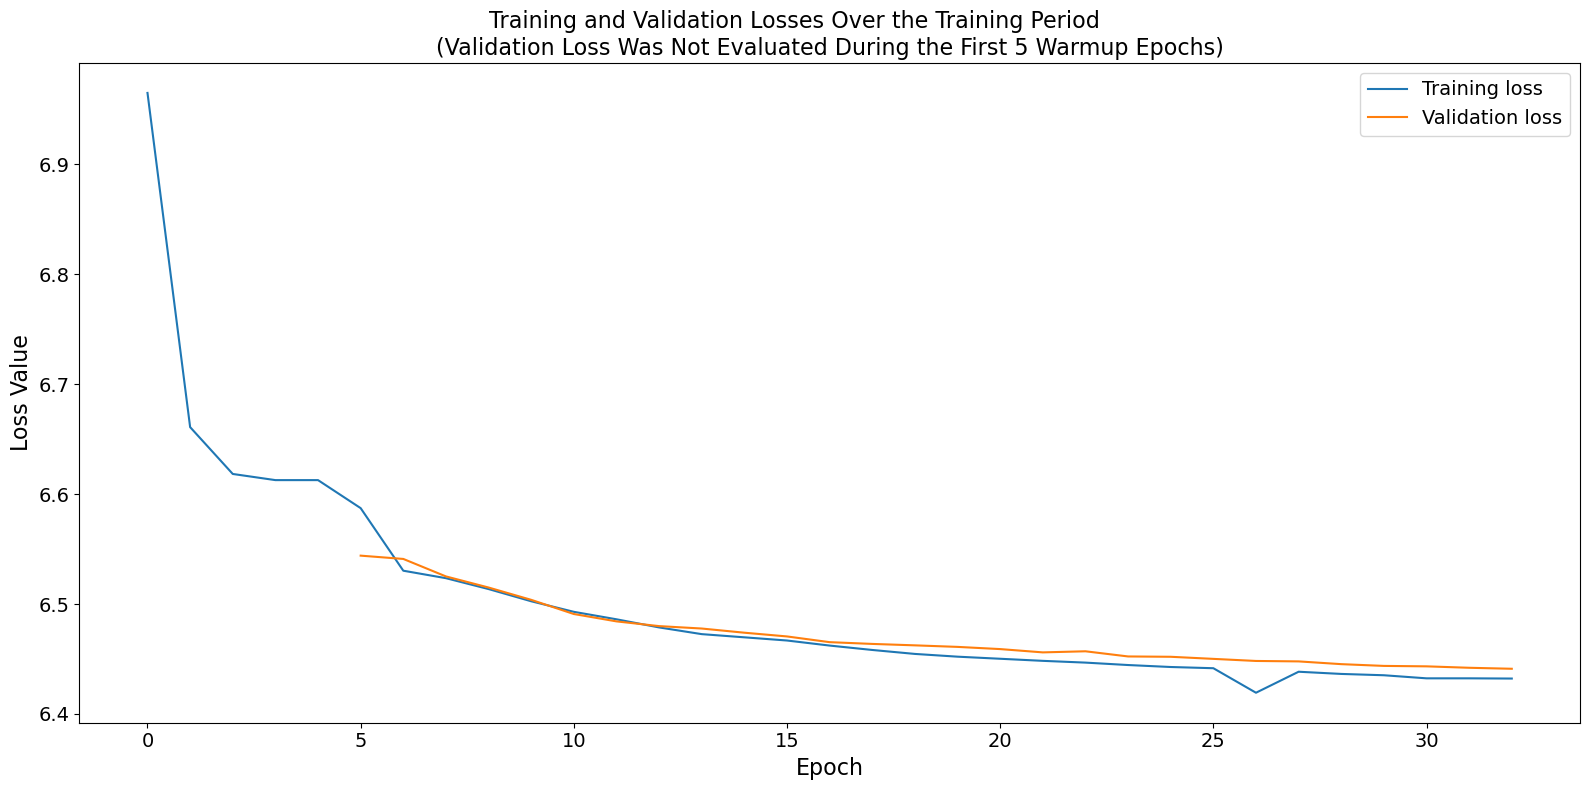

In [49]:
plt.figure(figsize=(16,8))
sn.lineplot(y=train_losses, x=range(len(train_losses)), label='Training loss')
sn.lineplot(y=val_losses, x=range(5,len(val_losses)+5), label='Validation loss')
plt.xlabel('Epoch', fontdict={'fontsize':16})
plt.ylabel('Loss Value', fontdict={'fontsize':16})
plt.title('Training and Validation Losses Over the Training Period\
          \n(Validation Loss Was Not Evaluated During the First 5 Warmup Epochs)', 
         fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop = { "size": 14 })
plt.tight_layout()

## Plot the accuracy on the validation set over the training period
Again, the warm-up period was not recorded.

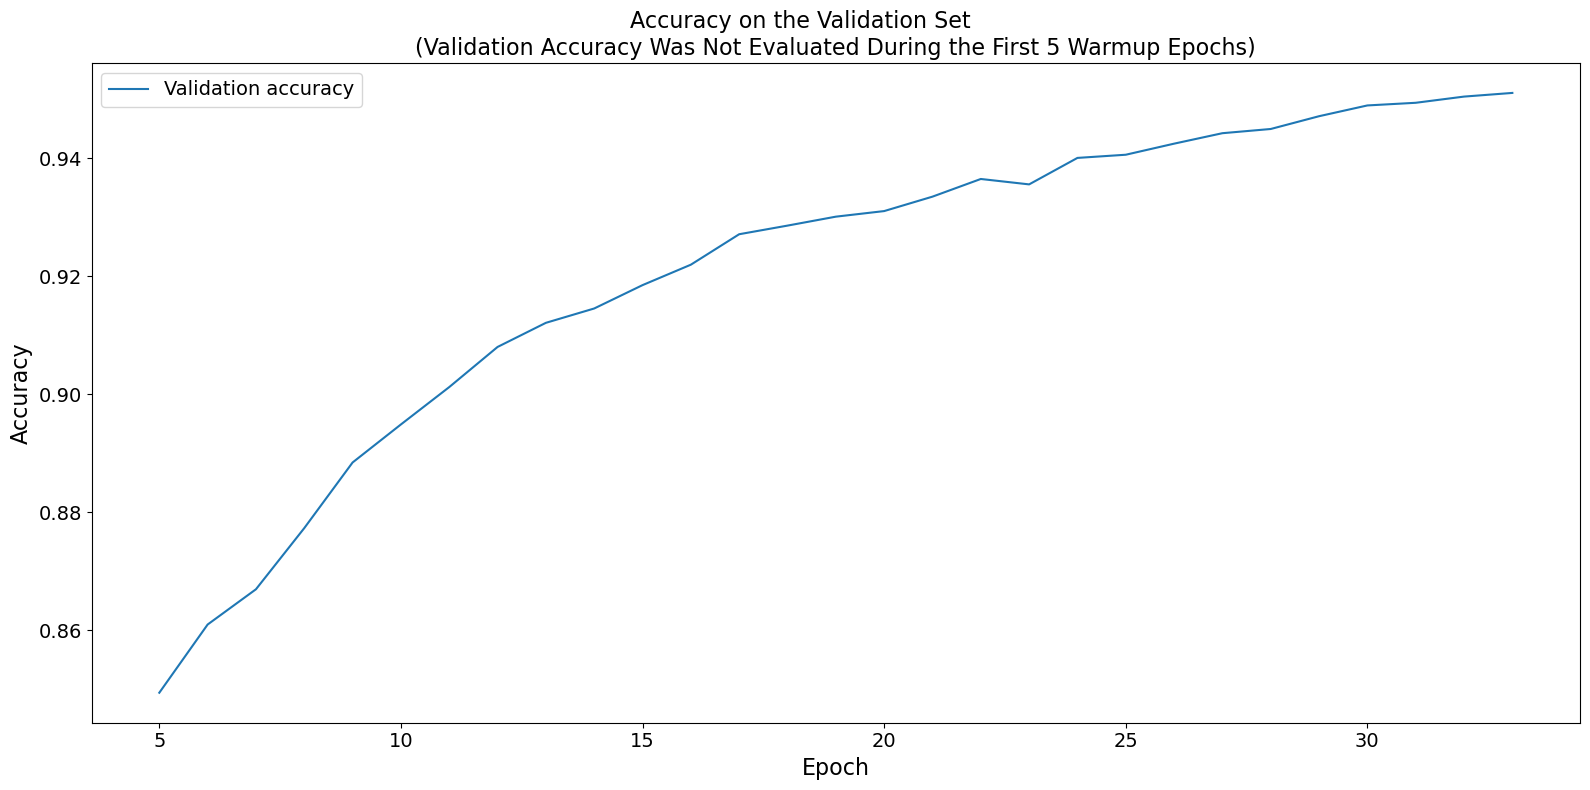

In [50]:
plt.figure(figsize=(16,8))
sn.lineplot(y=avg_accuracies, x=range(5,len(avg_accuracies)+5), label='Validation accuracy')
plt.xlabel('Epoch', fontdict={'fontsize':16})
plt.ylabel('Accuracy', fontdict={'fontsize':16})
plt.title('Accuracy on the Validation Set\
          \n(Validation Accuracy Was Not Evaluated During the First 5 Warmup Epochs)', 
         fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop = { "size": 14 })
plt.tight_layout()